# Baseline - 3D CNN - 4 Classifiers - Inference

In this notebook, we will train **four** 3D convolutional neural networks and combine their predictions in order to recognize a brain tumor.

For each case (i.e., person) we know whether the person suffered from cancer (1) or not (0). Each independent case has a dedicated folder identified by a five-digit number. Within each of these “case” folders, there are four sub-folders, each of them corresponding to an MRI scan, The MRI scans include:

* Fluid Attenuated Inversion Recovery (FLAIR)
* T1-weighted pre-contrast (T1w)
* T1-weighted post-contrast (T1Gd)
* T2-weighted (T2)

I am using the datas set created by [Jonathan Besomi](https://www.kaggle.com/c/rsna-miccai-brain-tumor-radiogenomic-classification/discussion/253000#1388021). Many thanks for creating the data set!

**3D images**
* each image has the following shape: Channel x Width x Height x Depth (i.e., 1 x Width x Height x Depth)
* *depth:* the depth represents the depth or the number of slices. (I tried various values >= 30. If for a given id, the depth <= the given value (e.g., 30), I replaced the missing depth slices with zero matrices (see [Zabir Al Nazi Nabil](https://www.kaggle.com/furcifer/torch-efficientnet3d-for-mri-no-train)))
* added some albumentation such as CLAHE, brightness, and CoarseDropout for the training images
* removed black pixels (see [Zabir Al Nazi Nabil](https://www.kaggle.com/furcifer/torch-efficientnet3d-for-mri-no-train))

**3D CNN** <br>
TODO: ResNet

#### Imports

In [1]:
import os
import random
import glob
import re

import pandas as pd

import numpy as np

import math

from functools import partial

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torchvision import transforms, utils
from torch.autograd import Variable

import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut

import cv2

import albumentations as A

from tqdm import tqdm

import wandb

import warnings
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", RuntimeWarning)

#### Seed

In [2]:
def set_seed(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True


set_seed(42)

#### Config

In [3]:
PATH = '..'

config = dict(
    # Pre-processing
    SLICE_NUMBER = 50, # >= 30
    REMOVE_BLACK_BOUNDARIES = True,
    DICOM=False,
    # Albumentation
    RRC_SIZE = 256,
    RRC_MIN_SCALE = 0.85,
    RRC_RATIO = (1., 1.),
    CLAHE_CLIP_LIMIT = 2.0,
    CLAHE_TILE_GRID_SIZE = (8, 8),
    CLAHE_PROB = 0.50,
    BRIGHTNESS_LIMIT = (-0.2,0.2),
    BRIGHTNESS_PROB = 0.40,
    HUE_SHIFT = (-15, 15),
    SAT_SHIFT = (-15, 15),
    VAL_SHIFT = (-15, 15),
    HUE_PROB = 0.64,
    COARSE_MAX_HOLES = 16,
    COARSE_PROB = 0.7,
    # Training
    N_EPOCHS = 15,
    BATCH_SIZE = 8,
    LEARNING_RATE = 0.001,
    WEIGHT_DECAY = 0.02,
    # Logging
    VERBOSE = False,
    MODELNAME = "02-3D-4-ResNet18"
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#### wandb

In [4]:
os.environ["WANDB_NOTEBOOK_NAME"] = "01-3D-4-ResNet"
wandb.login()
run = wandb.init(project='rsna-miccai', config=config)
config = wandb.config

wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find 01-3D-4-ResNet
wandb: Currently logged in as: gusto (use `wandb login --relogin` to force relogin)


### 1. Load Data

To create a 3D image, we will pick SLICE_NUMBER middle slices from each of the four MRI types (i.e., FLAIR, T1w, T1wCE, T2w). For example, if we set *SLICE_NUMBER=30*, each 3D image will have the shape: 1 x Width x Height x 30. Further, one image contains only the images from *one* MRI type as opposed to other notebooks where all MRI types are combined in a single image.

* If for a given MRI type, the number of images < SLICE_Number, than we will "fill up" the remaining *number_of_images - SLICE_NUMBER* slices with all black images
* We removed black pixels (for more information, see [here](https://www.kaggle.com/furcifer/torch-efficientnet3d-for-mri-no-train))

### 1.1 Utilities

#### 1.1.1 Augmentation

In [5]:
train_transform = A.Compose([
    A.RandomResizedCrop(
        config.RRC_SIZE, config.RRC_SIZE,            
        scale=(config.RRC_MIN_SCALE, 1.0),
        ratio=config.RRC_RATIO,
        p=1.0
    ),
    A.CLAHE(
        clip_limit=config.CLAHE_CLIP_LIMIT,
        tile_grid_size=config.CLAHE_TILE_GRID_SIZE,
        p=config.CLAHE_PROB
    ),
    A.RandomBrightnessContrast(
        brightness_limit=config.BRIGHTNESS_LIMIT,
        p=config.BRIGHTNESS_PROB
    ),
    A.HueSaturationValue(
        hue_shift_limit=config.HUE_SHIFT, 
        sat_shift_limit=config.SAT_SHIFT, 
        val_shift_limit=config.VAL_SHIFT, 
        p=config.HUE_PROB
    ),
    A.CoarseDropout(
        max_holes=config.COARSE_MAX_HOLES,
        p=config.COARSE_PROB
    ),
    A.Normalize(
        mean=(123.675),
        std=(58.39),
        max_pixel_value=255.0,
        always_apply=True
    )
])

valid_transform = A.Compose([
    A.RandomResizedCrop( 
        config.RRC_SIZE, config.RRC_SIZE,            
        scale=(config.RRC_MIN_SCALE, 1.0),
        ratio=config.RRC_RATIO,
        p=1.0
    ),
    A.Normalize(
        mean=(123.675),
        std=(58.39),
        max_pixel_value=255.0,
        always_apply=True
    )
])

#### 1.1.2 Loading Images

In [6]:
def dicom_2_image(file, voi_lut=True, fix_monochrome=True):
    dicom = pydicom.read_file(file)
    # VOI LUT (if available by DICOM device) is used to
    # transform raw DICOM data to "human-friendly" view
    if voi_lut:
        img = apply_voi_lut(dicom.pixel_array, dicom)
    else:
        img = dicom.pixel_array
    if fix_monochrome and dicom.PhotometricInterpretation == "MONOCHROME1":
        img = np.amax(img) - img
    
    img = img - np.min(img)
    img = img / np.max(img)
    img = (img * 255).astype(np.uint8)
    return img

def get_3d_image(mri_type, aug, dicom):
    if config.VERBOSE:
        print(f"Length of folder: {len(mri_type)}")
    # Take SLICE_NUMBER slices from the middle
    threshold = config.SLICE_NUMBER // 2
    minimum_idx = len(mri_type)//2 - threshold if (len(mri_type)//2 - threshold) > 0 else 0
    maximum_idx = len(mri_type)//2 + threshold  # maximum can exceed the index
    if config.VERBOSE:
        print(f"Minimum {minimum_idx}")
        print(f"Maximum {maximum_idx}")
    # Create array which contains the images
    mri_img = []
    for file in mri_type[minimum_idx:maximum_idx]:
        if dicom:
            img = dicom_2_image(file)
        else:
            img = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
        if config.REMOVE_BLACK_BOUNDARIES:
            (x, y) = np.where(img > 0)
            if len(x) > 0 and len(y) > 0:
                x_mn = np.min(x)
                x_mx = np.max(x)
                y_mn = np.min(y)
                y_mx = np.max(y)
                if (x_mx - x_mn) > 10 and (y_mx - y_mn) > 10:
                    img = img[:,np.min(y):np.max(y)]
        if aug:
            transformed = train_transform(image=img)
            img = transformed["image"]
        else:
            transformed = valid_transform(image=img)
            img = transformed["image"]
        mri_img.append(np.array(img))
    mri_img = np.array(mri_img).T
    # If less than SLICE_NUMBER slices, add SLICE_NUMBER - mri_img.shape[-1] images with only zero values
    if mri_img.shape[-1] < config.SLICE_NUMBER:
        if config.VERBOSE:
            print(f"Current slices: {mri_img.shape[-1]}")
        n_zero = config.SLICE_NUMBER - mri_img.shape[-1]
        mri_img = np.concatenate((mri_img, np.zeros((config.RRC_SIZE, config.RRC_SIZE, n_zero))), axis = -1)
    if config.VERBOSE:
        print(f"Shape of mri_img: {mri_img.shape}")
    return mri_img
    

    
def load_images(scan_id, mri_type, aug=True, split="train", dicom=False):
    file_ext = "png"
    if dicom:
        file_ext = "dcm"
    if config.VERBOSE:
        print(f"Scan id {scan_id}")
        
    # Ascending sort
    if mri_type == "FLAIR":
        flair = sorted(glob.glob(f"{PATH}/{split}/{scan_id}/FLAIR/*.{file_ext}"), key=lambda f: int(re.sub('\D', '', f)))
        img = get_3d_image(flair, aug, dicom)
    elif mri_type == "T1w":
        t1w = sorted(glob.glob(f"{PATH}/{split}/{scan_id}/T1w/*.{file_ext}"), key=lambda f: int(re.sub('\D', '', f)))
        img = get_3d_image(t1w, aug, dicom)
    elif mri_type == "T1wCE":
        t1wce = sorted(glob.glob(f"{PATH}/{split}/{scan_id}/T1wCE/*.{file_ext}"), key=lambda f: int(re.sub('\D', '', f)))
        img = get_3d_image(t1wce, aug, dicom)
    else:
        t2w = sorted(glob.glob(f"{PATH}/{split}/{scan_id}/T2w/*.{file_ext}"), key=lambda f: int(re.sub('\D', '', f)))
        img = get_3d_image(t2w, aug, dicom)
    
    # Return 3D image: ChannelsxWidthxHeightxDepth
    img = img.reshape((1,config.RRC_SIZE,config.RRC_SIZE,config.SLICE_NUMBER))
    return img

#### Example

The first row represents images with augmentation and the second row images without augmentation.

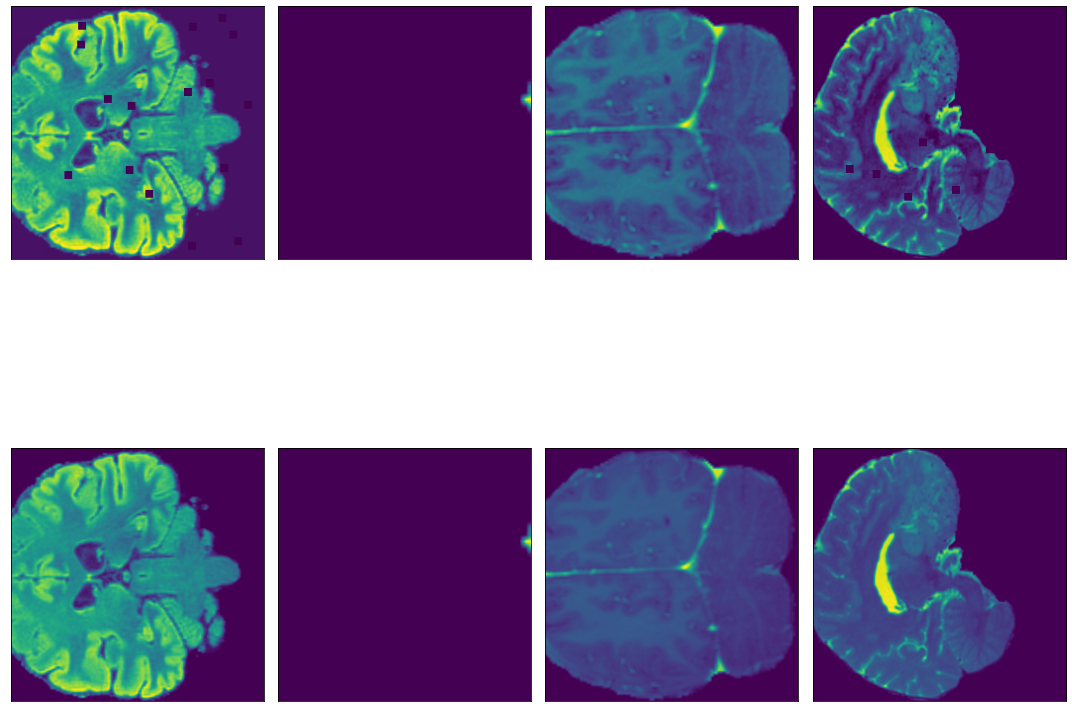

In [7]:
scan_id = "00000"
slice_nb = 0

figure, axes = plt.subplots(2,4, figsize=(15,15))

flair_3d_image = load_images(scan_id, "FLAIR", aug=True)
flair_3d_image_fs = flair_3d_image[0,:,:,slice_nb]
t1w_3d_image = load_images(scan_id, "T1w", aug=True)
t1w_3d_image_fs = t1w_3d_image[0,:,:,slice_nb]
t1wce_3d_image = load_images(scan_id, "T1wCE", aug=True)
t1wce_3d_image_fs = t1wce_3d_image[0,:,:,slice_nb]
t2w_3d_image = load_images(scan_id, "T2w", aug=True)
t2w_3d_image_fs = t2w_3d_image[0,:,:,slice_nb]

im = axes[0,0].imshow(flair_3d_image_fs)
im = axes[0,1].imshow(t1w_3d_image_fs)
im = axes[0,2].imshow(t1wce_3d_image_fs)
im = axes[0,3].imshow(t2w_3d_image_fs)

for ax in axes[0]:
    ax.set_xticks([])
    ax.set_yticks([])

flair_3d_image = load_images(scan_id, "FLAIR", aug=False)
flair_3d_image_fs = flair_3d_image[0,:,:,slice_nb]
t1w_3d_image = load_images(scan_id, "T1w", aug=False)
t1w_3d_image_fs = t1w_3d_image[0,:,:,slice_nb]
t1wce_3d_image = load_images(scan_id, "T1wCE", aug=False)
t1wce_3d_image_fs = t1wce_3d_image[0,:,:,slice_nb]
t2w_3d_image = load_images(scan_id, "T2w", aug=False)
t2w_3d_image_fs = t2w_3d_image[0,:,:,slice_nb]

im = axes[1,0].imshow(flair_3d_image_fs)
im = axes[1,1].imshow(t1w_3d_image_fs)
im = axes[1,2].imshow(t1wce_3d_image_fs)
im = axes[1,3].imshow(t2w_3d_image_fs)

for ax in axes[1]:
    ax.set_xticks([])
    ax.set_yticks([])

figure.tight_layout()
plt.show()

### 1.2 Dataset and Dataloader

Create a PyTorch Dataset and DataLoader **for each** MRI type

In [8]:
# Load ids and labels and make a stratified 80:20 split
df_test = pd.read_csv(f"{PATH}/sample_submission.csv")

In [9]:
class RSNADataset(Dataset):
    def __init__(self, ids, labels, mri_type = "FLAIR", split = "train", dicom=False):
        self.ids = ids
        self.labels = labels
        self.mri_type = mri_type
        self.split = split
        self.dicom = dicom
        
        if split == "train":
            remove_ids = [709, 109, 123]
            self.ids = [id_ for id_ in self.ids if id_ not in remove_ids]  
    
    def __len__(self):
        return len(self.ids)
    
    def __getitem__(self, idx):
        patient_id = self.ids[idx]
        patient_id = str(patient_id).zfill(5)
        if self.split == "train":
            imgs = load_images(patient_id, self.mri_type, aug=True, dicom=self.dicom)
        elif self.split == "valid":
            imgs = load_images(patient_id, self.mri_type, aug=False, dicom=self.dicom)
        else:
            imgs = load_images(patient_id, self.mri_type, aug=False, split=self.split, dicom=self.dicom)
        # Normalize
        imgs = imgs - imgs.min()
        imgs = (imgs + 1e-5) / (imgs.max() - imgs.min() + 1e-5)

        if self.split != "test":
            label = self.labels[idx]
            return torch.tensor(imgs, dtype = torch.float32), torch.tensor(label, dtype = torch.long)
        else:
            label = self.labels[idx]
            return torch.tensor(imgs, dtype = torch.float32), torch.tensor(self.ids[idx], dtype = torch.long)

In [12]:
# FLAIR DataLoader
test_flair_ds = RSNADataset(df_test["BraTS21ID"].to_numpy(), df_test["MGMT_value"].to_numpy(), mri_type="FLAIR", split='test')
test_flair_dl = DataLoader(test_flair_ds, batch_size=config.BATCH_SIZE, shuffle=False)

# T1w DataLoader
test_t1w_ds = RSNADataset(df_test["BraTS21ID"].to_numpy(), df_test["MGMT_value"].to_numpy(), mri_type="T1w", split='test')
test_t1w_dl = DataLoader(test_t1w_ds, batch_size=config.BATCH_SIZE, shuffle=False)

# T1wCE DataLoader
test_t1wce_ds = RSNADataset(df_test["BraTS21ID"].to_numpy(), df_test["MGMT_value"].to_numpy(), mri_type="T1wCE", split='test')
test_t1wce_dl = DataLoader(test_t1wce_ds, batch_size=config.BATCH_SIZE, shuffle=False)

# T2w DataLoader
test_t2w_ds = RSNADataset(df_test["BraTS21ID"].to_numpy(), df_test["MGMT_value"].to_numpy(), mri_type="T2w", split='test')
test_t2w_dl = DataLoader(test_t2w_ds, batch_size=config.BATCH_SIZE, shuffle=False)

In [13]:
images, labels = next(iter(test_flair_dl))
print(f"Shape of the batch {images.shape}")
print(f"Batch size: {images.shape[0]}")
print(f"Number of channels each image has: {images.shape[1]}")
print(f"Size of each image is: {images.shape[2]}x{images.shape[3]}")
print(f"Depth of each channel/sequence: {images.shape[-1]}")

Shape of the batch torch.Size([8, 1, 256, 256, 50])
Batch size: 8
Number of channels each image has: 1
Size of each image is: 256x256
Depth of each channel/sequence: 50


### 1.3 Model

#### 1.3.1 3D ResNet18

For more information, see [MedicalNet](https://github.com/Tencent/MedicalNet)

In [14]:
def conv3x3x3(in_planes, out_planes, stride=1):
    return nn.Conv3d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)


def conv1x1x1(in_planes, out_planes, stride=1):
    return nn.Conv3d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, downsample=None):
        super().__init__()

        self.conv1 = conv3x3x3(in_planes, planes, stride)
        self.bn1 = nn.BatchNorm3d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3x3(planes, planes)
        self.bn2 = nn.BatchNorm3d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out
    
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1, downsample=None):
        super().__init__()

        self.conv1 = conv1x1x1(in_planes, planes)
        self.bn1 = nn.BatchNorm3d(planes)
        self.conv2 = conv3x3x3(planes, planes, stride)
        self.bn2 = nn.BatchNorm3d(planes)
        self.conv3 = conv1x1x1(planes, planes * self.expansion)
        self.bn3 = nn.BatchNorm3d(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block, layers, block_inplanes, n_input_channels=1, conv1_t_size=7, conv1_t_stride=1, no_max_pool=False,
                 shortcut_type='B', widen_factor=1.0, n_classes=2):
        super().__init__()
        
        # For wider ResNets only
        block_inplanes = [int(x * widen_factor) for x in block_inplanes]

        self.in_planes = block_inplanes[0]  # 64
        self.no_max_pool = no_max_pool

        # First Block: Convolutional Layer + Batch Normalization + ReLu + Max Pooling
        self.conv1 = nn.Conv3d(n_input_channels, self.in_planes, kernel_size=(conv1_t_size, 7, 7), stride=(conv1_t_stride, 2, 2),
                               padding=(conv1_t_size // 2, 3, 3), bias=False)
        self.bn1 = nn.BatchNorm3d(self.in_planes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool3d(kernel_size=3, stride=2, padding=1)
        # Example ResNet18: Each layer consists of two residual blocks and two residual connections
        self.layer1 = self._make_layer(block, block_inplanes[0], layers[0], shortcut_type)
        self.layer2 = self._make_layer(block, block_inplanes[1], layers[1], shortcut_type, stride=2)
        self.layer3 = self._make_layer(block, block_inplanes[2], layers[2], shortcut_type, stride=2)
        self.layer4 = self._make_layer(block, block_inplanes[3], layers[3], shortcut_type, stride=2)

        self.avgpool = nn.AdaptiveAvgPool3d((1, 1, 1))
        self.fc = nn.Linear(block_inplanes[3] * block.expansion, n_classes)

        # Initialization
        for m in self.modules():
            # He initialization
            if isinstance(m, nn.Conv3d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm3d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _downsample_basic_block(self, x, planes, stride):
        out = F.avg_pool3d(x, kernel_size=1, stride=stride)
        zero_pads = torch.zeros(out.size(0), planes - out.size(1), out.size(2), out.size(3), out.size(4))
        if isinstance(out.data, torch.cuda.FloatTensor):
            zero_pads = zero_pads.cuda()

        out = torch.cat([out.data, zero_pads], dim=1)

        return out

    def _make_layer(self, block, planes, blocks, shortcut_type, stride=1):
        downsample = None
        if stride != 1 or self.in_planes != planes * block.expansion:
            if shortcut_type == 'A':
                downsample = partial(self._downsample_basic_block, planes=planes * block.expansion, stride=stride)
            else:
                downsample = nn.Sequential(conv1x1x1(self.in_planes, planes * block.expansion, stride), 
                                           nn.BatchNorm3d(planes * block.expansion))

        layers = []
        layers.append(block(in_planes=self.in_planes, planes=planes, stride=stride, downsample=downsample))
        self.in_planes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.in_planes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        if not self.no_max_pool:
            x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)

        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [16]:
flair_model = ResNet(Bottleneck, [3, 4, 6, 3], [64, 128, 256, 512])
flair_model.load_state_dict(torch.load("../models/01-3D-4-ResNet18-pretrained-FLAIR-roc-0.68.pt"))
flair_model.to(device)
t1w_model = ResNet(Bottleneck, [3, 4, 6, 3], [64, 128, 256, 512])
t1w_model.load_state_dict(torch.load("../models/01-3D-4-ResNet18-pretrained-T1w-roc-0.61.pt"))
t1w_model.to(device)
t1wce_model = ResNet(Bottleneck, [3, 4, 6, 3], [64, 128, 256, 512])
t1wce_model.load_state_dict(torch.load("../models/01-3D-4-ResNet18-pretrained-T1wCE-roc-0.59.pt"))
t1wce_model.to(device)
t2w_model = ResNet(Bottleneck, [3, 4, 6, 3], [64, 128, 256, 512])
t2w_model.load_state_dict(torch.load("../models/01-3D-4-ResNet18-pretrained-T2w-roc-0.71.pt"))
t2w_model.to(device)

ResNet(
  (conv1): Conv3d(1, 64, kernel_size=(7, 7, 7), stride=(1, 2, 2), padding=(3, 3, 3), bias=False)
  (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool3d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv3d(64, 64, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
      (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (bn2): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv3d(64, 256, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
      (bn3): BatchNorm3d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv3d(64, 256, k

### 1.4 Testing


In [18]:
def submission(net, test_dl):
    y_hats = None
    idx_list = []
    
    net.eval()
    for xb, idxb in tqdm(test_dl, desc="Testing"):
        xb = xb.to(device)
        y_hat = net(xb)
        y_hat = F.softmax(y_hat)[:,1].cpu().detach().numpy()
        if y_hats is None:
            y_hats = y_hat
            idx_list = idxb.numpy()
        else:
            y_hats = np.concatenate((y_hats, y_hat), axis=0)
            idx_list = np.concatenate((idx_list, idxb.numpy()), axis=0)
    
    return y_hats, idx_list

In [19]:
y_flair_hats, idx_list = submission(flair_model, test_flair_dl)
y_t1w_hats, idx_list = submission(t1w_model, test_t1w_dl)
y_t1wce_hats, idx_list = submission(t1wce_model, test_t1wce_dl)
y_t2w_hats, idx_list = submission(t2w_model, test_t2w_dl)

Testing: 100%|██████████| 11/11 [00:16<00:00,  1.51s/it]


In [24]:
df = pd.DataFrame({'BraTS21ID': idx_list, 'FLAIR': y_flair_hats, 'T1w': y_t1w_hats, 'T1wCE': y_t1wce_hats,
                   'T2w': y_t2w_hats})
df["MGMT_value"] = (df["FLAIR"] + df["T1w"] + df["T1wCE"] + df["T2w"]) / 4

In [25]:
df_submission = df[["BraTS21ID", "MGMT_value"]]
df_submission.to_csv("submission.csv", index=False)
df_submission

Done